In [1]:
import pandas as pd
import base
import os
import pickle
from keras.models import load_model
import numpy as np

2024-01-05 06:25:58.221397: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 06:25:58.257179: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 06:25:58.257233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 06:25:58.258230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 06:25:58.264579: I tensorflow/core/platform/cpu_feature_guar

In [2]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [3]:
loaded_posmodel = load_model("Data/03_model/pos/pos_class_model_3")
    
with open('Data/03_model/pos/posmodelcolumn_all.pkl', 'rb') as file:
    loaded_poscolumns = pickle.load(file)
        
with open('Data/03_model/pos/pos_replacement_dict_all.pkl', 'rb') as file:
    replacement_dict = pickle.load(file)

In [4]:
df1 = base.import_sqlite3_data('Data/01_sqlite_data/ms2_lipid2.db')
df_pos = df1.query('Comment.str.contains("Mix")').query('Ontology.isin(["PC","PE","EtherPC","EtherPE"])').query('Adducttype.str.contains("\+")')[['Ontology','Metabolitename','MSMSspectrum','AverageMz']].\
    reset_index().rename(columns={'index':'ID'})

In [5]:
df_pos = pd.read_csv('Data/02_basedata/pos/df_pos.csv')[['Unnamed: 0','Ontology','Metabolitename','MSMSspectrum','AverageMz']].rename(columns={'Unnamed: 0':'ID'})

In [7]:
df_rep = pd.DataFrame(list(replacement_dict.items()), columns=['Ontology', 'Value'])

In [8]:
df_pos2 = df_pos[df_pos['Ontology'].isin(df_pos[df_pos['Ontology'].isin(df_rep.Ontology.tolist())].Ontology.drop_duplicates().tolist())]

In [9]:
df_pos_exp_ = base.spectrum_tidy_f(df_pos2)
df_pos_neuloss_ = base.neutralloss_tidy_f(df_pos2)
df_pos_data = base.spectrum_neutralloss_table(df_pos_exp_, df_pos_neuloss_)

df_pos_data['div2'] = df_pos_data['AverageMz'].round().astype(int) % 2
df_pos_data['modnum'] = base.cal_mod(df_pos_data['AverageMz'])

In [10]:
columns_to_drop = ['ID', 'AverageMz', 'Metabolitename', 'Ontology']
df_pos_data.columns = df_pos_data.columns.astype('str')
X1_test = df_pos_data[loaded_poscolumns]
y_pred_test = loaded_posmodel.predict(X1_test)

265/265 [==============================] - 2s 7ms/step


In [12]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_replacement_dict_reversed = pd.DataFrame(columns=['replaced_num', 'replaced_name'])
for replacement, original in replacement_dict_reversed.items():
    df_replacement_dict_reversed = pd.concat([df_replacement_dict_reversed, pd.DataFrame({'replaced_num': [replacement], 'replaced_name': [original]})], ignore_index=True)

In [13]:
df_pred_test = pd.DataFrame(y_pred_test).rename(columns=df_replacement_dict_reversed['replaced_name'])
df_pred_test = pd.concat([df_pred_test, df_pos2.reset_index(drop=True)[['ID']]], axis=1).set_index('ID')

y_pred_test_max = np.argmax(y_pred_test, axis=1)
y_pred_test_max_ = np.vectorize(base.apply_replacement)(y_pred_test_max, replacement_dict_reversed)

df_pred_test['pred_1class'] = y_pred_test_max_
df_pred_test['pred_class'] = df_pred_test.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_pred_test['pred_number'] = df_pred_test['pred_class'].apply(lambda x: len(x.split(',')))

In [14]:
df_pred_result = df_pred_test[['pred_1class','pred_class','pred_number']].reset_index()

In [15]:
df_pred_resultx = df_pred_result.merge(df_pos2[['ID','Metabolitename','Ontology']],how='inner',on='ID')#.query('Ontology == "MLCL"')

In [16]:
df_pred_resultx.query('pred_class.str.contains("PC")').query('pred_class.str.contains("PE")').query('pred_1class.isin(["PC","PE","EtherPC","EtherPE"])')

,ID,pred_1class,pred_class,pred_number,Metabolitename,Ontology
567,3538,PE,"PE:0.959,PC:0.022,EtherPC:0.015",3,PE 35:2,PE
569,3540,PE,"PE:0.766,PC:0.157,EtherPC:0.062",3,PC O-33:2,EtherPC
674,3684,EtherPC,"EtherPC:0.908,PC:0.061,PE:0.023",3,PC O-37:6,EtherPC
863,3948,PE,"PE:0.548,PC:0.194,SM:0.133,TG:0.041,EtherPC:0....",6,PE 46:1,PE
895,3993,EtherPC,"EtherPC:0.647,PE:0.173,PC:0.133,SM:0.036",4,PC 45:2,PC
927,4041,PC,"PC:0.218,EtherPC:0.217,SM:0.184,TG:0.079,PI:0....",9,PC 48:2|PC 18:1_30:1,PC
6070,32385,EtherPC,"EtherPC:0.627,PE:0.371",2,PC O-34:4,EtherPC
6100,32424,EtherPC,"EtherPC:0.886,PE:0.076,PC:0.033",3,PC O-36:7,EtherPC
6863,34149,PC,"PC:0.637,PE:0.278,TG:0.028,EtherPC:0.013,PG:0.01",5,PG 34:0|PG 16:0_18:0,PG
7228,34638,EtherPC,"EtherPC:0.777,EtherPE:0.106,PE:0.043,PC:0.02",4,PE P-38:6|PE P-18:1_20:5,EtherPE


In [17]:
df_pos_data_posint = df_pos_data.set_index('ID').drop(columns=['AverageMz', 'Metabolitename', 'Ontology', 'div2', 'modnum', 'MSMSspectrum'])
df_pos_data_posint = df_pos_data_posint[[col for col in df_pos_data_posint.columns.astype(str) if '-' not in col]]

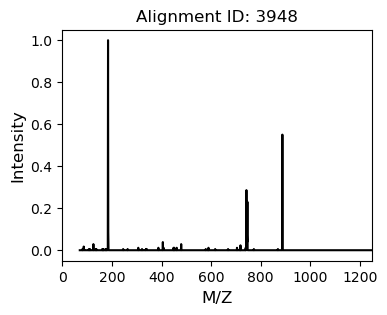

In [18]:
import matplotlib.pyplot as plt

Alignmnentid = 3948 #3993 #36122#32385#34638
df1= pd.DataFrame(df_pos_data_posint.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/pos/data_id3948_pcpemix.svg', format='svg', bbox_inches='tight')
plt.show()

In [20]:
element_list = df_pos[df_pos['ID'] == Alignmnentid]['MSMSspectrum'].str.split(' ')

mz_list = []
int_list = []

for element in element_list:
    for i in element:
        i_div = i.split(':')
        mz = i_div[0]
        int_val = i_div[1]

        mz_list.append(mz)
        int_list.append(int_val)

df = pd.DataFrame(list(zip(mz_list, int_list))).rename(columns={0:'mz',1:'int'}).astype(float)
df.query('int > 30')

,mz,int
1,86.09647,36.0
5,124.99915,60.0
14,184.07291,2062.0
15,185.07649,177.0
24,405.41019,80.0
31,479.45383,36.0
43,741.67511,590.0
44,742.68060,36.0
46,743.68164,139.0
47,744.68640,80.0


feces data

In [6]:
df_replacement_dict = pd.DataFrame(columns=['replaced_name', 'replaced_num'])
for replacement, original in replacement_dict.items():
    df_replacement_dict = pd.concat([df_replacement_dict, pd.DataFrame({'replaced_name': [replacement], 'replaced_num': [original]})], ignore_index=True)

In [7]:
df_pos_data2x = pd.read_csv('Data/02_basedata/pos/pos2.csv')
df_ont_val = pd.DataFrame(df_pos_data2x.Ontology.value_counts()).reset_index().\
merge(df_replacement_dict, how='inner', left_on = 'Ontology', right_on = 'replaced_name').drop(columns='replaced_name')
df_ont_val['val'] = 1 / df_ont_val['count']

In [8]:
df_pos_height = pd.read_csv('Data/07_projectohno/pos/pos_Height_0_2023_11_01_18_22_40.txt', sep='\t',header=4, delimiter=None)\
[['Alignment ID','Average Mz', 'Metabolite name', 'Adduct type', 'MS/MS assigned','Ontology', 'INCHIKEY', 'SMILES', 'MS/MS spectrum', 'Comment']]

MS2をもつすべてについての予測

In [9]:
df_pos_height['Alignment ID'] = df_pos_height['Alignment ID'].astype(int)
df_pos_height_ms2 = df_pos_height[~df_pos_height['MS/MS spectrum'].isna()].reset_index(drop=True)

df_pos_exp_ = base.spectrum_tidy_f2(df_pos_height_ms2)
df_pos_neuloss_ = base.neutralloss_tidy_f2(df_pos_height_ms2)
df_pos_data = base.spectrum_neutralloss_table_f2(df_pos_exp_, df_pos_neuloss_)

df_pos_data['div2'] = df_pos_data['Average Mz'].round().astype(int) % 2
df_pos_data['modnum'] = base.cal_mod(df_pos_data['Average Mz'])

columns_to_drop = ['Alignment ID', 'Average Mz', 'Metabolite name', 'Ontology']
df_pos_data.columns = df_pos_data.columns.astype('str')
X1_test = df_pos_data[loaded_poscolumns]
y_pred_test = loaded_posmodel.predict(X1_test)

In [ ]:
replacement_dict_reversed = {value: key for key, value in replacement_dict.items()}

df_replacement_dict_reversed = pd.DataFrame(columns=['replaced_num', 'replaced_name'])
for replacement, original in replacement_dict_reversed.items():
    df_replacement_dict_reversed = pd.concat([df_replacement_dict_reversed, pd.DataFrame({'replaced_num': [replacement], 'replaced_name': [original]})], ignore_index=True)

df_pred_test = pd.DataFrame(y_pred_test).rename(columns=df_replacement_dict_reversed['replaced_name'])
df_pred_test = pd.concat([df_pred_test, df_pos_height_ms2[['Alignment ID']]], axis=1).set_index('Alignment ID')

In [ ]:
y_pred_test_max = np.argmax(y_pred_test, axis=1)
y_pred_test_max_ = np.vectorize(base.apply_replacement)(y_pred_test_max, replacement_dict_reversed)

df_pred_test['pred_1class'] = y_pred_test_max_
df_pred_test['pred_class'] = df_pred_test.drop('pred_1class', axis=1).apply(base.create_pred_class, axis=1)
df_pred_test['pred_number'] = df_pred_test['pred_class'].apply(lambda x: len(x.split(',')))

df_pred_result_all = df_pred_test[['pred_1class','pred_class','pred_number']].reset_index()

In [ ]:
df_pred_result_all.query('pred_class.str.contains("PC")').query('pred_class.str.contains("PE")').query('pred_1class.isin(["PC", "PE"])')

In [ ]:
df_pred_result_all['Alignment ID'] = df_pred_result_all['Alignment ID'].astype(int)
df_neg_data_x2 = df_pos_data[[col for col in df_pos_data.columns.astype(str) if '-' not in col]]
df_pred_result_all_X = df_pos_height_ms2[['Alignment ID','Metabolite name','Ontology']].\
merge(df_pred_result_all, how='right', on='Alignment ID').\
      merge(df_neg_data_x2.reset_index(), how='inner', on='Alignment ID')

In [ ]:
df_pred_result_all2 = df_pred_result_all.merge(df_pos_height_ms2[['Alignment ID','Average Mz','Metabolite name','Ontology','SMILES','MS/MS spectrum']], how='left', on='Alignment ID')

In [ ]:
df_pos_data_all = df_pos_data.set_index('Alignment ID').drop(columns=['Average Mz', 'Metabolite name', 'Ontology', 'div2', 'modnum'])
df_pos_data_all = df_pos_data_all[[col for col in df_pos_data_all.columns.astype(str) if '-' not in col]]

In [ ]:
import matplotlib.pyplot as plt

Alignmnentid = 11330

df1= pd.DataFrame(df_pos_data_all.loc[Alignmnentid]).reset_index().rename(columns={'index':'mz',Alignmnentid:'exp'}).astype('float')

fig, axs = plt.subplots(1, 1, figsize=(4, 3))

axs.plot(df1['mz'], df1['exp'], color='black')
axs.set_xlabel('M/Z', fontsize=12)
axs.set_ylabel('Intensity', fontsize=12)
axs.set_title('Alignment ID: ' + str(Alignmnentid), fontsize=12)
axs.set_xlim(0, 1250)

plt.savefig('Data/svg/model/result/pos/feces_id12871_gdcae.svg', format='svg', bbox_inches='tight')

plt.show()

In [ ]:
element_list = df_pos_height_ms2[df_pos_height_ms2['Alignment ID']==11330]['MS/MS spectrum'].str.split(' ')

mz_list = []
int_list = []

for element in element_list:
    for i in element:
        i_div = i.split(':')
        mz = i_div[0]
        int_val = i_div[1]

        mz_list.append(mz)
        int_list.append(int_val)

df = pd.DataFrame(list(zip(mz_list, int_list))).rename(columns={0:'mz',1:'int'}).astype(float)
df.query('int >= 40')